# Insights from Failed Orders

This data project has been used as a take-home assignment in the recruitment process for the data science positions at Gett.

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. 

In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

### Assignment
Please complete the following tasks.

- Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
- Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
- Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
- Plot the distribution of average ETA by hours. How can this plot be explained?

*BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.*

### Data Description
We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

- order_datetime - time of the order
- origin_longitude - longitude of the order
- origin_latitude - latitude of the order
- m_order_eta - time before order arrival
- order_gk - order number
- order_status_key - status, an enumeration consisting of the following mapping:
    4 - cancelled by client,
    9 - cancelled by system, i.e., a reject
- is_driver_assigned_key - whether a driver has been assigned
- cancellation_time_in_seconds - how many seconds passed before cancellation

The data_offers data set is a simple map with 2 columns:

- order_gk - order number, associated with the same column from the orders data set
- offer_id - ID of an offer

### Practicalities
Make sure that the solution reflects your entire thought process including the preparation of data - it is more important how the code is structured rather than just the final result or plot.

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read data
offer = pd.read_csv("./datasets/data_offers.csv")
order = pd.read_csv("./datasets/data_orders.csv")

### Data description

In [3]:
# data_offer
offer.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [4]:
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
offer.shape, order.shape

((334363, 2), (10716, 8))

In [6]:
# looking at the order data, order_status, is_driver_assigned are categorical data
order.is_driver_assigned_key.unique(), order.order_status_key.unique()

(array([1, 0]), array([4, 9]))

- No nan values in order_status_key column => order table contains only canceled orders
- order_status_key = 4 means cancelled by clients, 9 mean cancelled by system

Lets split the data

In [7]:
byClient=order[order.order_status_key == 4]
byClient.shape

(7307, 8)

In [8]:
bySystem=order[order.order_status_key == 9]
bySystem.shape

(3409, 8)

Clearly, Clients have cancelled almost 2x higher then number of orders cancelled by system. It can be a cause of concern for the company (Gett).

Lets investigate further, why clients and system have cancelled the orders from other columns.

In [9]:
# 1. order_datetime
byClient['order_hour'] = pd.to_datetime(byClient['order_datetime']).dt.hour

/var/folders/pq/49c42znj69q0p6zs3s9qd_yr0000gn/T/ipykernel_2353/1629248865.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  byClient['order_hour'] = pd.to_datetime(byClient['order_datetime']).dt.hour
/var/folders/pq/49c42znj69q0p6zs3s9qd_yr0000gn/T/ipykernel_2353/1629248865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byClient['order_hour'] = pd.to_datetime(byClient['order_datetime']).dt.hour


<Axes: >

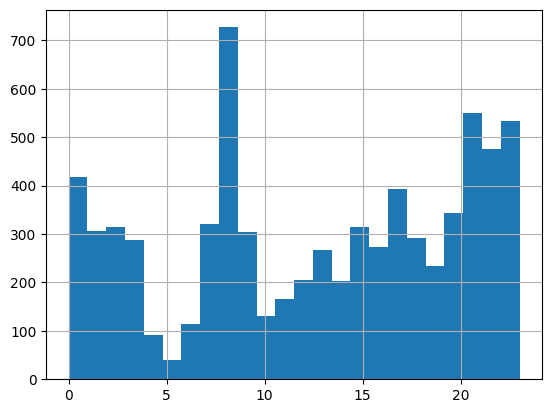

In [10]:
byClient['order_hour'].hist(bins=24)

histogram of time shows cancellation by clients is high:

**between 7am to 9am.**

Possible reason could be rush hour to reach to work. Which means high demand, higher ETA. Need to test with reason with m_order_eta column.


**between 10pm to mid-night**  

This could be lack of availability of drivers at late hours. Will test this reason with is_driver_assigned_key column

In [11]:
# 2: origin_longitude and origin_latitude
# using geomap and looking into location
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

/var/folders/pq/49c42znj69q0p6zs3s9qd_yr0000gn/T/ipykernel_2353/4085267979.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


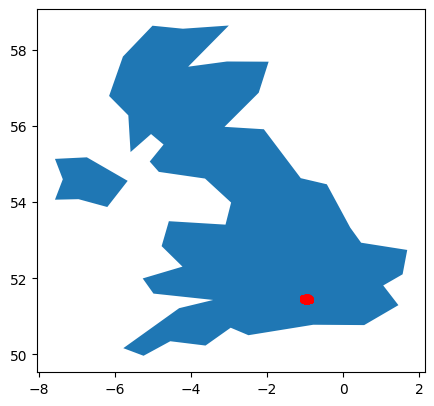

In [33]:
geometry = [Point(xy) for xy in zip(byClient['origin_longitude'], byClient['origin_latitude'])]
gdf = GeoDataFrame(byClient, geometry=geometry)   

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

uk = world[world.name == 'United Kingdom']

gdf.plot(ax=uk.plot(figsize=(5, 5)), marker='o', color='red', markersize=15);


Not much info can be gathered from location dataset. However, more deeper lever of spatial analysis can find some correlation with canceled order. For now, moving on to next columns.

In [43]:
# m_order_eta
# If eta is high, its a discomfort for customer, can cause cancellation.

byClient.m_order_eta.size, byClient.m_order_eta.isna().sum(), byClient.is_driver_assigned_key.sum()

(7307, 4496, 2811)

61.5% ETA values are **NAN** because "Driver is not assigned". Customer may have waited for some time and then cancelled the order.

In [44]:
byClient_noDriver = byClient[byClient['is_driver_assigned_key']==0]
byClient_Driver = byClient[byClient['is_driver_assigned_key']==1]

In [47]:
byClient_noDriver.cancellations_time_in_seconds.describe()

count    4496.000000
mean      110.371441
std       120.676021
min         3.000000
25%        38.000000
50%        88.000000
75%       157.000000
max      4097.000000
Name: cancellations_time_in_seconds, dtype: float64

In [51]:
byClient_noDriver.cancellations_time_in_seconds.isna().sum() 
# 0 : no NAN values, all clients waited for some time and then cancelled

0

<Axes: >

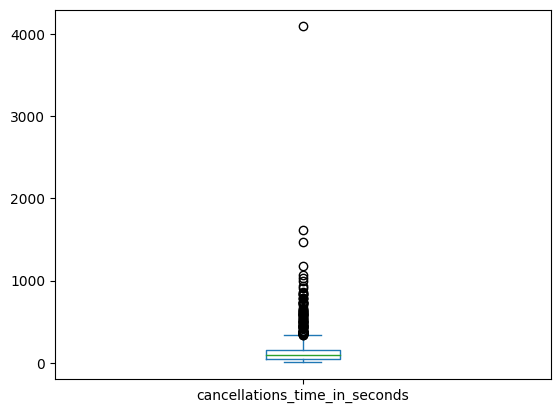

In [54]:
byClient_noDriver.cancellations_time_in_seconds.plot(kind='box')